# Introduction

Heart disease can lead to fatal heart attacks, so must be treated seriously. In this project, we will analyze past data of patients to try to predict heart disease in a person, with the person’s given medical records.

Our data set comes from the “Heart Disease Data Set” from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. This data set has attributes of patient's medical history and whether or not they have heart disease. We will be using the processed.cleveland.data data set to answer the question:

*Is it possible to use existing patient chart data with different attributes of the patient to predict the likelihood of a new patient having heart disease with the help of a classification model?*


<img src="https://hips.hearstapps.com/hmg-prod/images/281/lead-image-gettyimages-911641138-1-1518269574.jpg" width = "419">         <img src="https://static01.nyt.com/images/2022/05/17/well/09Well-Heart-Disease-Women/09Well-Heart-Disease-Women-superJumbo.jpg" width = "400">

In [27]:
### Run the R libraries 
library(repr)
library(tidyverse)
library(tidymodels)

options(repr.matrix.max.rows = 10) #This can only show 10 rows of the dataframe.


ERROR: Error: package or namespace load failed for ‘tidymodels’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 namespace ‘vctrs’ 0.6.0 is already loaded, but >= 0.6.1 is required


In [ ]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names= FALSE) #read directly from website
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "disease_type") #give column names according to the website
cleveland_data <- mutate(cleveland_data, disease_type = as_factor(disease_type), thal = as.numeric(thal), ca = as.numeric(ca))#change vector type to numeric and factor.
cleveland_data

### Cleaning the data by using filter() functions:
Our first step is to filter out the missing rows in the *thal* column and "?" in the *ca* column.

In [9]:
filter_cleveland_data <- cleveland_data |>
    filter(thal != "?", ca != "?") |> #filter out possiable ? and N/A values.
    drop_na()

In order to make a valid prediction, we will only look at whether or not patients have heart disease. *disease_type* has 4 values representing the presence of heart disease, so we mutate this column into "No = no heart disease" and "Yes = has heart disease"

In [10]:
new_cleveland_data <- filter_cleveland_data |> mutate(have_heart_disease = ifelse(disease_type == 0, "No", "Yes"), have_heart_disease = as_factor(have_heart_disease)) |> # Make a new column that see if this person has heart disease or not.
select(- disease_type) #Exclude the origenal column
new_cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,have_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,No
67,1,4,160,286,0,2,108,1,1.5,2,3,3,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Yes
37,1,3,130,250,0,0,187,0,3.5,3,0,3,No
41,0,2,130,204,0,2,172,0,1.4,1,0,3,No
56,1,2,120,236,0,0,178,0,0.8,1,0,3,No
62,0,4,140,268,0,2,160,0,3.6,3,2,3,Yes
57,0,4,120,354,0,0,163,1,0.6,1,0,3,No
63,1,4,130,254,0,2,147,0,1.4,2,1,7,Yes


# Method

**Data analysis** - Prepare and ready our data set

**Visualizing** - We visualize our selected variables with the target variable to confirm there is a strong relation between both.

**Selecting our predicting values** - We used forward selection on all variables to choose the variables which will predict results with most accuracy. We also condirmed these relation with the help of our visulizations.

**Splitting our dataset** - We split our data into training data set and testing data set 


**Building our classification model**

# Visulizations

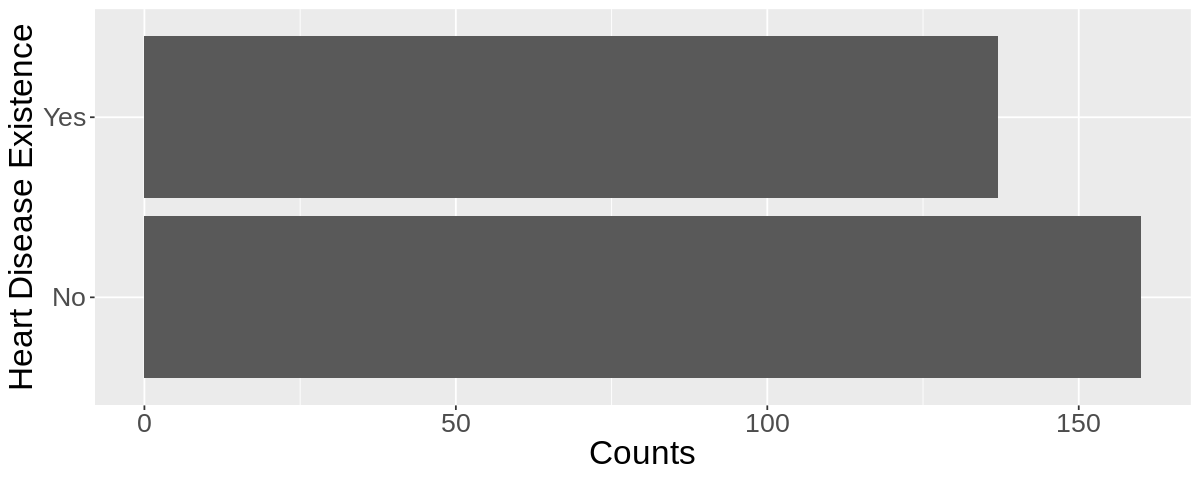

In [11]:
options(repr.plot.width = 10, repr.plot.height = 4)

counting_types <- new_cleveland_data |>
    group_by(have_heart_disease)|>
    summarize(types_count = n()) 

exsitance_plot<- counting_types |>
ggplot(aes( x = have_heart_disease,
            y = types_count)) +
    geom_bar(position='stack', stat='identity') +
    scale_fill_manual(values=c('red', 'purple'))+
    coord_flip() +
    labs(x = "Heart Disease Existence", y = "Counts") +
    theme(text = element_text(size = 20))
exsitance_plot

The table above shows the presence of heart disease in patients from the new_cleveland_data, it shows that 160 people dont have heart disease (have_heart_disease == "No") and 137 people have heart disease (have_heart_disease == "Yes").

`geom_smooth()` using formula = 'y ~ x'


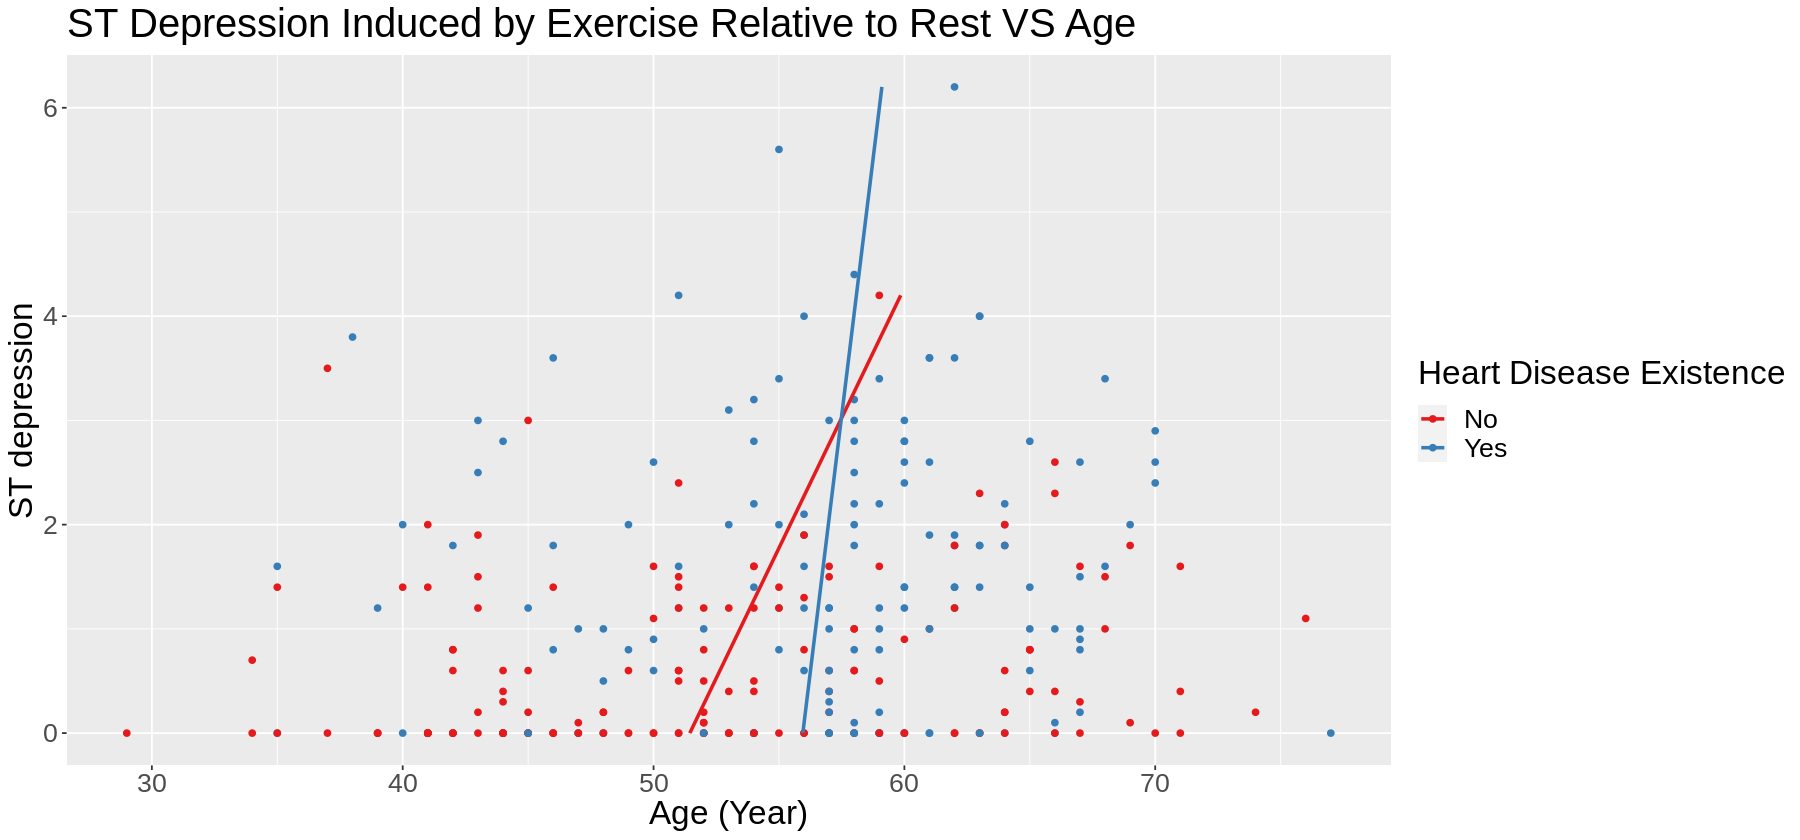

In [12]:
options(repr.plot.width = 15, repr.plot.height = 7)

oldpeak_vs_age<- new_cleveland_data |>
ggplot(aes( x = oldpeak,
            y = age, color= have_heart_disease)) +
    geom_point(stat = 'identity') +
    coord_flip() +
    labs(x = "ST depression", y = "Age (Year)", color = "Heart Disease Existence") +
    theme(text = element_text(size = 20)) +
    geom_smooth(method=lm,se=FALSE)+
    scale_color_brewer(palette="Set1")+
    ggtitle("ST Depression Induced by Exercise Relative to Rest VS Age")
oldpeak_vs_age

In this first plot above, there is a tendency of higher heart disease presence with higher age and higher ST depression.

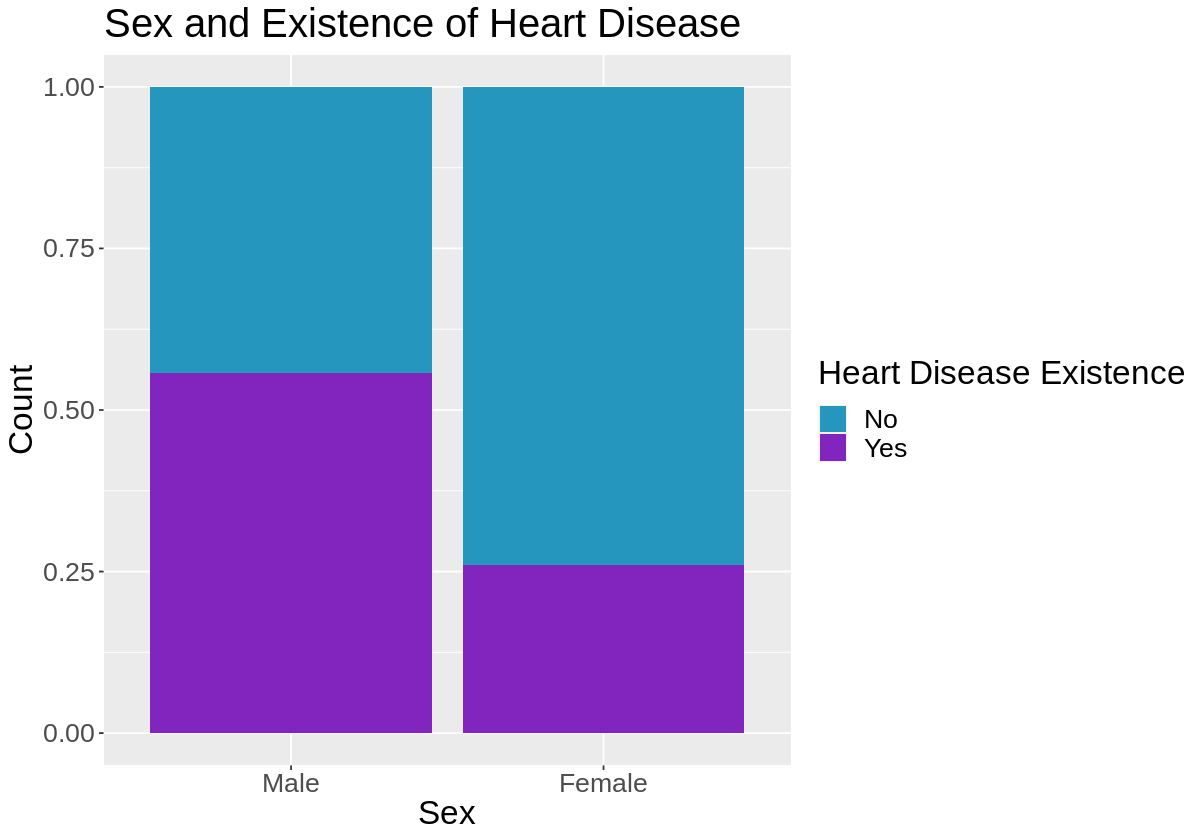

In [13]:
options(repr.plot.width = 10, repr.plot.height = 7)


sex_plot<- new_cleveland_data |>
    mutate(sex = ifelse(sex == 0, "Female", "Male")) |>
    mutate(sex = as_factor(sex)) |>
    ggplot(aes(x = sex, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Sex", y = "Count", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Sex and Existence of Heart Disease")
sex_plot

In this data set, heart disease is more prevalant in males.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


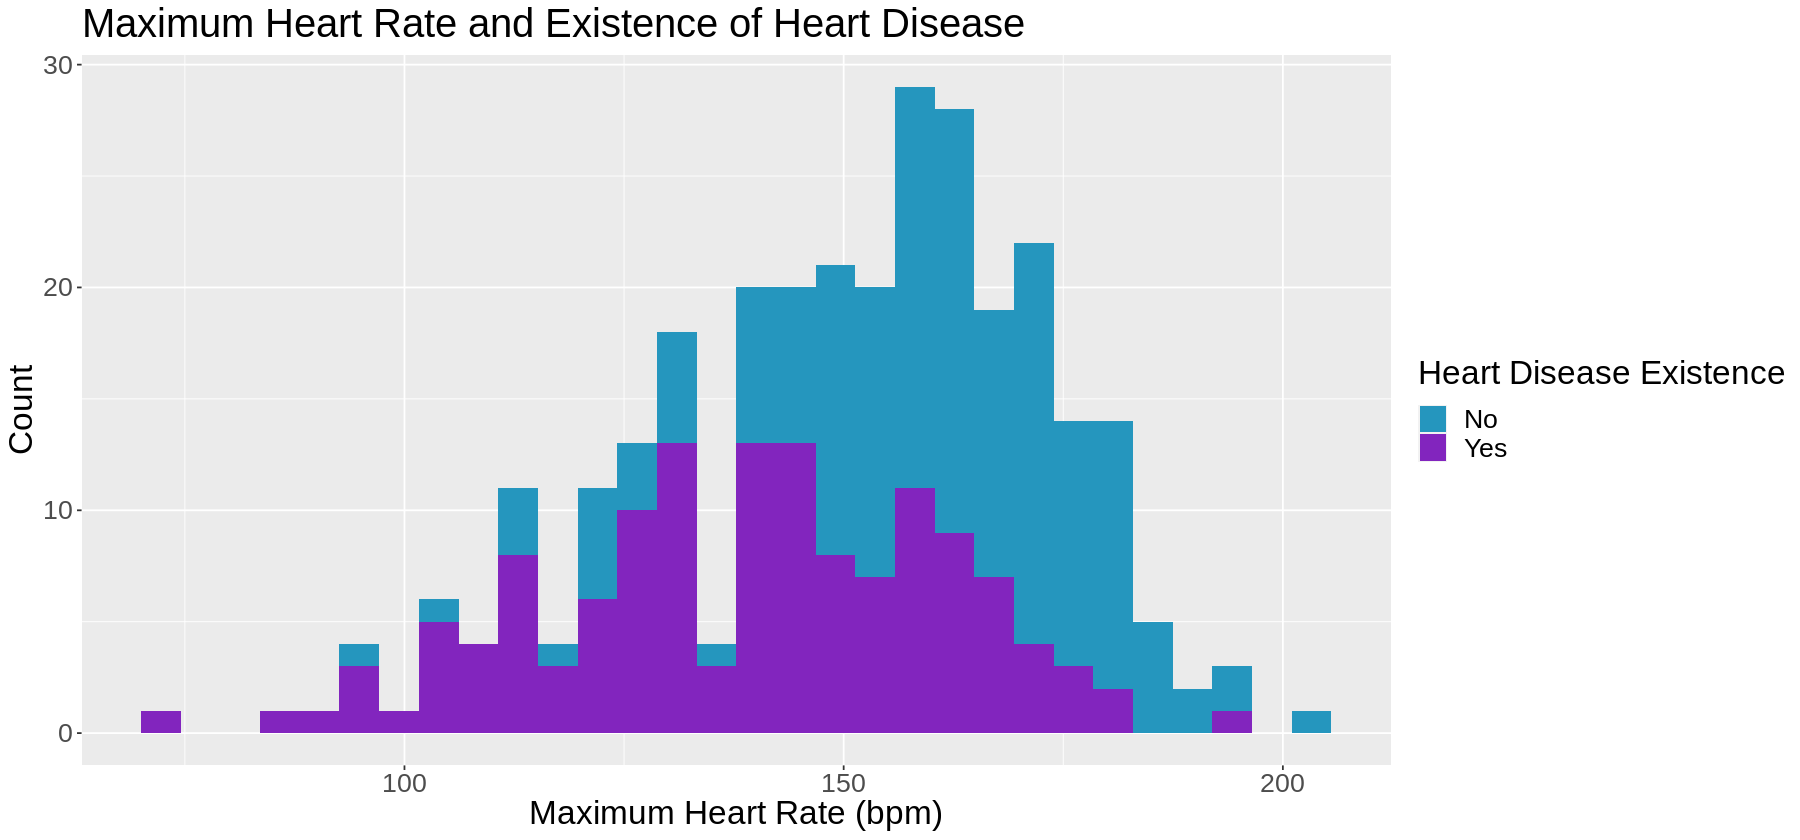

In [14]:
options(repr.plot.width = 15, repr.plot.height = 7)

thalach_plot<- new_cleveland_data |>
ggplot(aes(x = thalach,fill = have_heart_disease)) +
    geom_histogram() +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Maximum Heart Rate (bpm)", y = "Count", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Maximum Heart Rate and Existence of Heart Disease")
thalach_plot

A lower heart rate is more strongly correlated with the presence of heart disease.

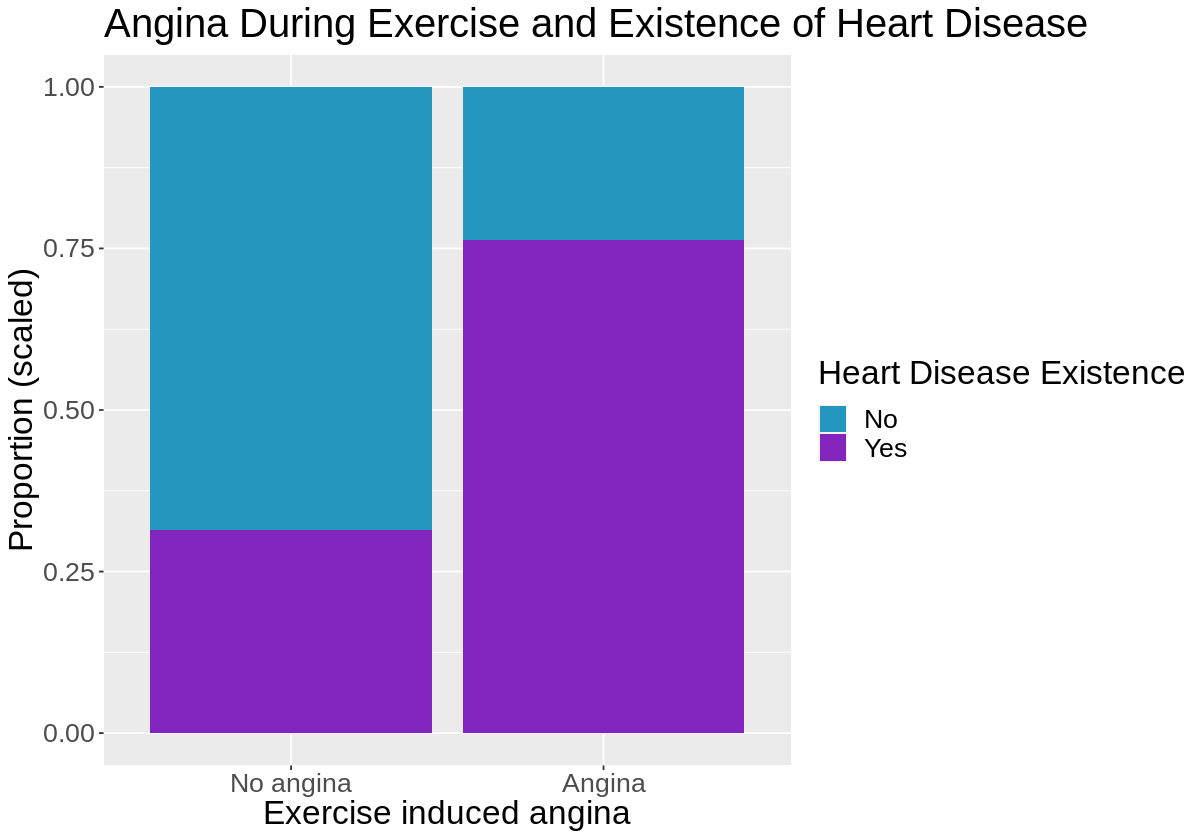

In [15]:
options(repr.plot.width = 10, repr.plot.height = 7)

exang_plot<- new_cleveland_data |>
    mutate(exang = ifelse(exang == 0, "No angina", "Angina")) |>
    mutate(exang = as_factor(exang)) |>
    ggplot(aes(x = exang, fill = have_heart_disease)) +
    geom_bar(position = "fill") +

    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Exercise induced angina", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Angina During Exercise and Existence of Heart Disease")
exang_plot

Patients who experience exercise induced angina have a greater likelihood of developing heart disease.

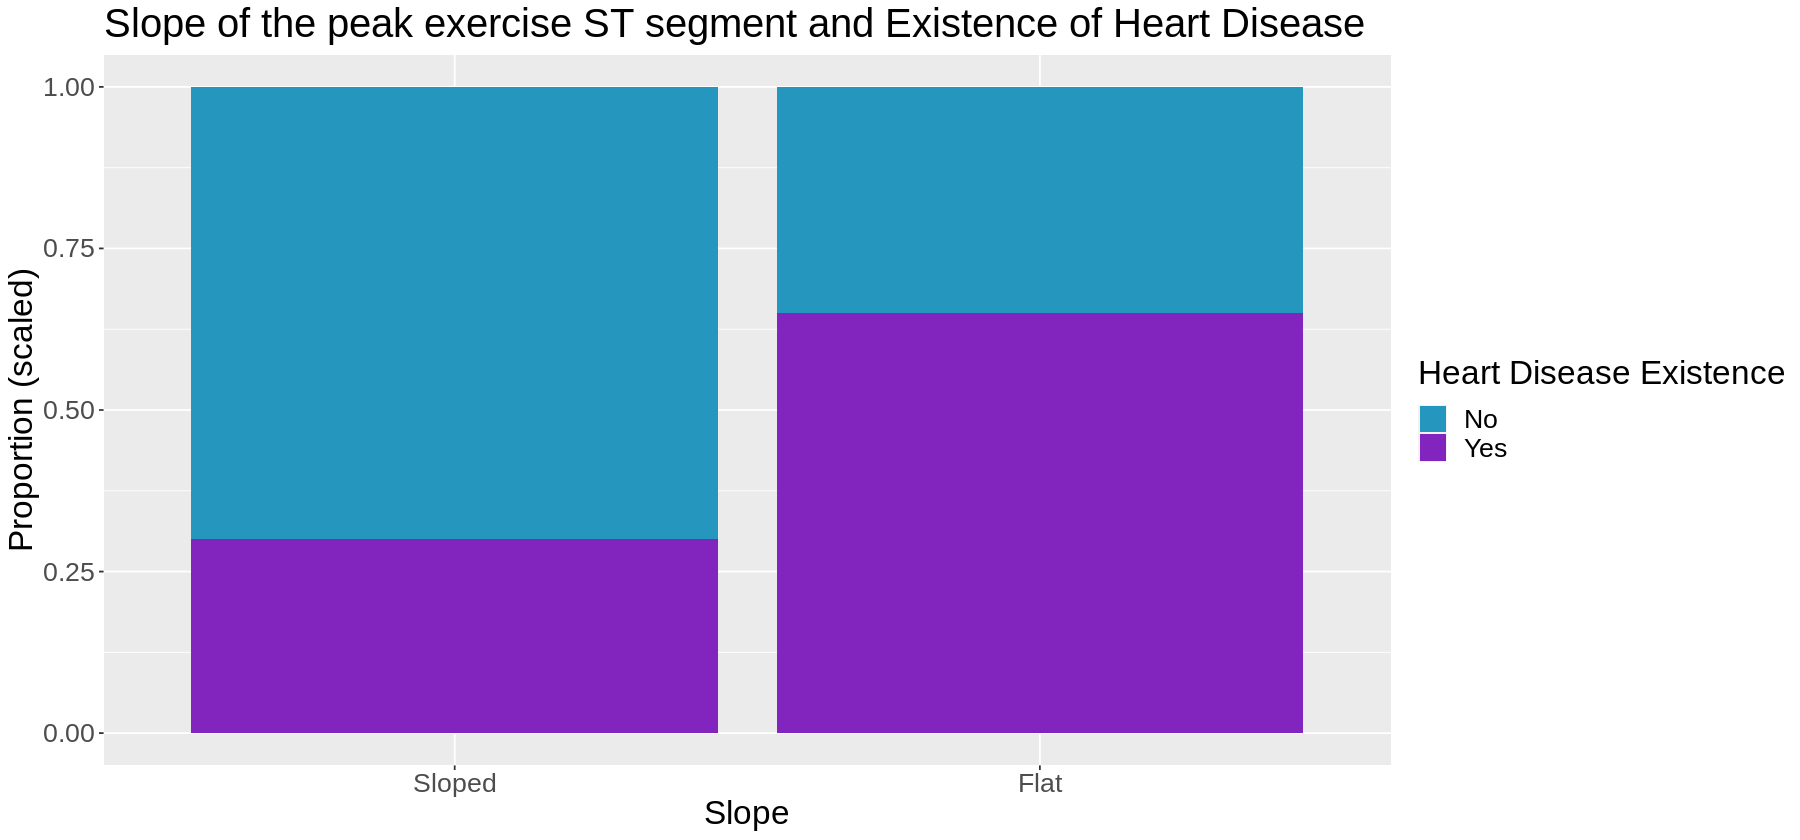

In [16]:
options(repr.plot.width = 15, repr.plot.height = 7)

slope_plot<- new_cleveland_data |>
     mutate(slope = ifelse(slope == 2, "Flat", "Sloped")) |>
    mutate(slope = as_factor(slope)) |>
    ggplot(aes(x = slope, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Slope", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Slope of the peak exercise ST segment and Existence of Heart Disease")
slope_plot

Having a flat slope of the peak exercise ST segment of an electrocardiogram has a higher proportion of heart disease.

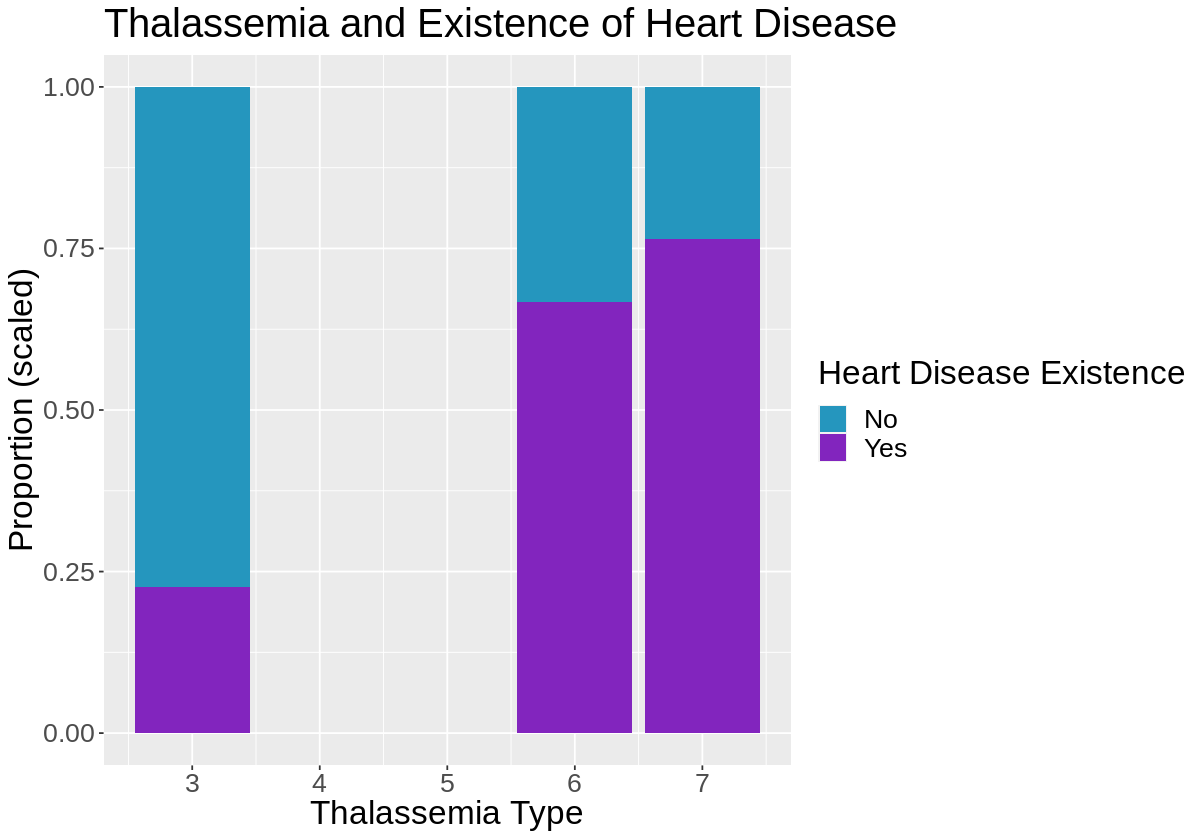

In [17]:
options(repr.plot.width = 10, repr.plot.height = 7)

thal_plot<- new_cleveland_data |>
    ggplot(aes(x = thal, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Thalassemia Type", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Thalassemia and Existence of Heart Disease")
thal_plot

A reversible defect of thalassemia has the highest relative presence of heart disease.

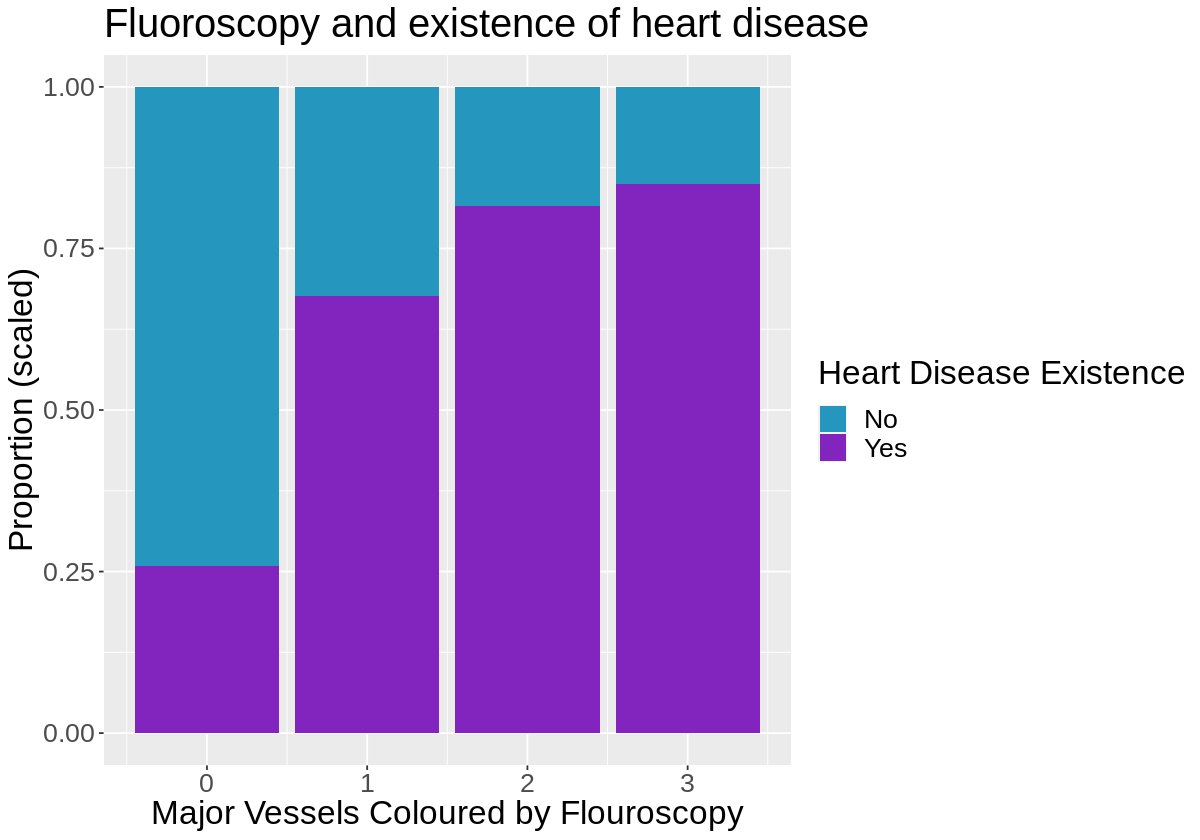

In [18]:
options(repr.plot.width = 10, repr.plot.height = 7)

ca_plot<- new_cleveland_data |>
    ggplot(aes(x = ca, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Major Vessels Coloured by Flouroscopy", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Fluoroscopy and existence of heart disease")
ca_plot

More major vessels coloured by fluoroscopy leads to higher proportions of heart disease.

# Splitting our dataset

After conducting the first data analysis step, we obtained 297 observations that can be utilized for further analysis. Our subsequent step involves dividing the data into two sets, training and test sets. We have decided to use a proportion of 0.75 for training and 0.25 for testing, meaning that 75% of the 297 observations will be assigned to the training set, while the remaining 25% will be placed in a test set. We have set the seed value to 233 for reference.

In [20]:
# Set the seed.
set.seed(233)

# Split the data into 75% and 25%.
data_split <- initial_split(new_cleveland_data, prop = 0.75, strata = have_heart_disease)  

heart_train_set <- training(data_split)   
heart_test_set <- testing(data_split)


ERROR: Error in initial_split(new_cleveland_data, prop = 0.75, strata = have_heart_disease): could not find function "initial_split"


# Forward selection

In [ ]:
#set.seed(233)
# #select every predictors
# names <- colnames(heart_train_set |> 
# select(age:thal))

# #create a tibble to store the results
# heart_acc <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#      set_engine("kknn") |>
#      set_mode("classification")

# heart_vfold <- vfold_cv(heart_train_set, v = 5, strata = have_heart_disease)

# n_total <- length(names)

# selected <- c()
     
# #for every size from 1 to the total number of predictors

# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("have_heart_disease", "~", paste(preds_new, collapse="+"))

#         heart_recipe <- recipe(as.formula(model_string), data = heart_train_set) |>
#                           step_scale(all_predictors()) |>
#                           step_center(all_predictors())

     
#         acc <- workflow() |>
#           add_recipe(heart_recipe) |>
#           add_model(knn_spec) |>
#           tune_grid(resamples = heart_vfold, grid = 10) |>
#           collect_metrics() |>
#           filter(.metric == "accuracy") |>
#           summarize(mx = max(mean))
#         acc <- acc$mx |> unlist()

      
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     heart_acc <- heart_acc |> 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }

# print(heart_acc)

<img src="DSCI Forward selection.png" width = "900">

[Table 1.1]

The table [Table1.1] above displays the accuracy of different models after the addition of a new predictor. We observed that the accuracy kept increasing until the 9th predictor been added. This means that we will reach the highest accuracy while having 8 predictors. It is clear from the data that the accuracy of the models increases as more significant variables are incorporated into the model. According to our table, we chose these X variables:

1. `thalach`
2. `ca`
3. `thal`
4. `exang`
5. `cp`
6. `oldpeak`
7. `age`
8. `trestbps`

## Building our classification model

### Creating a recipe

To prepare our training data for the classification model, we begin by creating a recipe. We included both the scale and centre functions to make sure that all X predictor variables have a mean of 0 and standard deviation of 1. 

In [ ]:
set.seed(233)
heart_recipe <- recipe(have_heart_disease ~ thalach + ca + thal + exang + cp + oldpeak + age + trestbps, #set up our recipe
                       data = heart_train_set) |>
                step_scale(all_predictors()) |> #scale and center all our data
                step_center(all_predictors())

### Creating a tuning model

In [28]:
set.seed(233)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn")|>
                set_mode("classification")

k_vals <- tibble(neighbors=seq(from=1, to=20, by=1))

heart_vfold <- vfold_cv(heart_train_set, v = 10, strata = have_heart_disease)

heart_results <- workflow()|>
                add_recipe(heart_recipe)|>
                add_model(knn_spec)|>
                tune_grid(resamples = heart_vfold, grid = k_vals)|>
                collect_metrics()|>
                filter(.metric == "accuracy") 

accuracy_plot <- heart_results |>
                ggplot(aes(x = neighbors, y = mean * 100))+
                geom_point()+
                geom_line()+
                labs(x = "Neighbors", y = "Accuracy Estimate(%)")+
                scale_x_continuous(breaks = seq(0, 20, by = 1)) +
                scale_y_continuous(limits = c(75, 90))+
                theme(text = element_text(size = 20))
accuracy_plot

ERROR: Error in set_mode(set_engine(nearest_neighbor(weight_func = "rectangular", : could not find function "set_mode"


In [ ]:
set.seed(233)
accuracy <- heart_results |> 
      filter(.metric == "accuracy")
best_k <- accuracy |>
          filter(mean == max(mean)) |>        
          select(neighbors)

best_k_value <- best_k |>
slice(1)|>
pull()

best_k_value

From the graph above we can observe that using 7 neighbours will give us the highest accuracy for this model. Hence, we wiil use `k = 7` in our k-nn model.

## Creating our model according to the best K value.

In [ ]:
set.seed(233)

#Feed the best k value we picked to make our final classification model:
heart_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_value) |>
              set_engine("kknn") |>
              set_mode("classification")

heart_model <- workflow() |>
             add_recipe(heart_recipe) |>
             add_model(heart_best_spec) |>
             fit(data = heart_train_set)


#Feed our test set into the model to see the prediction accuracy:
heart_predictions <- predict(heart_model, heart_test_set) |>
                     bind_cols(heart_test_set) 

#Calculate the accuracy as a percentage:
predicted_accuracy <- heart_predictions |>
   metrics(truth = have_heart_disease, estimate = .pred_class) |>
   filter(.metric == "accuracy") |>
   select(.metric, .estimate)
                     
predicted_accuracy

#Produce the accuracy matrix:
matrix <- heart_predictions |> 
    conf_mat(truth = have_heart_disease, estimate = .pred_class)

matrix

From the matrix above we can do some analysis: 64 out of a total of 75 predictions are correct, and 11 out of 75 predictions are wrong, meaning this model has a 85.33% accuracy.

# Discussion:

Considering our final accuracy of 85.33%, this is not high enough to accurately determine the prescence of heart disease. Since heart disease can be fatal, the accuracy must be very high. The confusion matrix above shows that approximately 12% (9/75) of the cases of heart disease were not detected by our model. In a real world setting these numbers would not be satisfactory. However, our accuracy despite being low still detected most cases. Hence, we determine from the results of this report that using predictors along with a classification model should not be trusted as a definitive answer when trying to predict the prescence of heart disease. Despite this, it may be useful as an additional tool alongside others to prompt inspection of early cases. If a positive prediction is detected, doctors may appoint patients a proper checkup, and inform the patient to keep their health in check.

The accuracy itself does not match our initial prediction of having a high accuracy. With the different data analysis methods such as forward selection, cross-validation, and selecting the `k` value which would return the highest accuracy, we believed that it would lead to a high accuracy. However, there may be more factors to heart disease than the data in our data set, and it is difficult to predict a complex disease with little preliminary information.



The source we got our data from had more data, but from other locations. We could look into whether there is a significant difference in the results based on different geographical regions.

## References

1. Centers for Disease Control and Prevention. (2022, September 8). Heart disease and stroke. Centers for Disease Control and Prevention. Retrieved March 15, 2023, from https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity. 
2. Centers for Disease Control and Prevention. (2023, March 21). About heart disease. Centers for Disease Control and Prevention. Retrieved March 15, 2023, from https://www.cdc.gov/heartdisease/about.htm#:~:text=What%20is%20heart%20disease%3F,can%20cause%20a%20heart%20attack.
3. Khan, M. I. G., & SpringerLink ebooks - Medicine. (2005). Heart disease diagnosis and therapy: A practical approach (2nd;2. Aufl.; ed.). Humana Press.
4. Myerson, S. G. (2021). CMR in evaluating valvular heart disease; diagnosis, severity, and outcomes. JACC. Cardiovascular Imaging, 14(10), 2020-2032. https://doi.org/10.1016/j.jcmg.2020.09.029
5. Singh, P., Singh, S., &amp; Pandi-Jain, G. S. (2018, March 15). Effective heart disease prediction system using data mining techniques. International journal of nanomedicine. Retrieved March 15, 2023, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5863635/#:~:text=The%20diagnosis%20of%20heart%20disease%20is%20usually%20based%20on%20signs,and%20lack%20of%20physical%20exercise. 

Image References: https://hips.hearstapps.com/hmg-prod/images/281/lead-image-gettyimages-911641138-1-1518269574.jpg 

https://static01.nyt.com/images/2022/05/17/well/09Well-Heart-Disease-Women/09Well-Heart-Disease-Women-superJumbo.jpg
